### Load in Packages

In [1]:
import os
os.environ["HF_HOME"] = "/home/shared/.cache/huggingface"
os.environ["HUGGINGFACE_HUB_CACHE"] = "/home/shared/.cache/huggingface/hub"

In [2]:
from peft import LoraConfig, get_peft_model
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
import json as pd
import numpy as np
import pickle

### Check GPU Availability

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

True


### Load Data

In [4]:
import pandas as pd

file_path = "Data/PubMedQA_cleaned.json"
QA_data = pd.read_json(file_path)
data = QA_data

In [5]:
# Calculate class weights based on the training data
class_counts = data['gold_index'].value_counts().sort_index().values 
total_samples = len(data)
class_weights = torch.tensor([total_samples / count for count in class_counts], dtype=torch.float).to(device)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: [338 110 552]
Class weights: tensor([2.9586, 9.0909, 1.8116], device='cuda:0')


### Hugging Face Login

In [6]:
import os
from huggingface_hub import login
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("hf_token")
login(token=hf_token)

### Set LoRA Config & Load in Teacher Model

In [7]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["self_attn.q_proj", "self_attn.v_proj", "self_attn.k_proj", "self_attn.out_proj", "fc1", "fc2"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

teacher_model_name = "microsoft/BioGPT-Large-PubMedQA"

teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModelForCausalLM.from_pretrained(
    teacher_model_name,
    torch_dtype=torch.float16,     
    device_map="auto"
)

lora_model = get_peft_model(teacher_model, lora_config)

# Load previously saved LoRA weights
lora_model.load_state_dict(torch.load("/home/shared/best_models/best_model.pth"), strict=False)

lora_model.enable_input_require_grads()
# lora_model.gradient_checkpointing_enable() # Can save GPU's vRAM but slow down training


In [8]:
# Check the model's layers
for name, module in teacher_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(name)


biogpt.layers.0.self_attn.k_proj.base_layer
biogpt.layers.0.self_attn.k_proj.lora_A.default
biogpt.layers.0.self_attn.k_proj.lora_B.default
biogpt.layers.0.self_attn.v_proj.base_layer
biogpt.layers.0.self_attn.v_proj.lora_A.default
biogpt.layers.0.self_attn.v_proj.lora_B.default
biogpt.layers.0.self_attn.q_proj.base_layer
biogpt.layers.0.self_attn.q_proj.lora_A.default
biogpt.layers.0.self_attn.q_proj.lora_B.default
biogpt.layers.0.self_attn.out_proj.base_layer
biogpt.layers.0.self_attn.out_proj.lora_A.default
biogpt.layers.0.self_attn.out_proj.lora_B.default
biogpt.layers.0.fc1.base_layer
biogpt.layers.0.fc1.lora_A.default
biogpt.layers.0.fc1.lora_B.default
biogpt.layers.0.fc2.base_layer
biogpt.layers.0.fc2.lora_A.default
biogpt.layers.0.fc2.lora_B.default
biogpt.layers.1.self_attn.k_proj.base_layer
biogpt.layers.1.self_attn.k_proj.lora_A.default
biogpt.layers.1.self_attn.k_proj.lora_B.default
biogpt.layers.1.self_attn.v_proj.base_layer
biogpt.layers.1.self_attn.v_proj.lora_A.default


In [9]:
# Assign eos_token as pad_token
teacher_tokenizer.pad_token = teacher_tokenizer.eos_token

In [10]:
class LoraClassificationModel(nn.Module):
    def __init__(self, lora_model, hidden_size, num_classes=3, class_weights=None):
        super(LoraClassificationModel, self).__init__()
        self.lora_model = lora_model
        self.class_weights = class_weights

        # Multi-layer perceptron (MLP) classification head
        self.classification_head = nn.Sequential(
            nn.Linear(hidden_size, 768),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(768, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        # Use the LoRA model to get the hidden states
        outputs = self.lora_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        # Get the last hidden state of the last layer
        cls_hidden_state = outputs.hidden_states[-1][:, -1, :]

        logits = self.classification_head(cls_hidden_state)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fn(logits.float(), labels)

        return logits, loss


In [11]:
# Wrapping the model with LoRA
num_classes = 3
model = LoraClassificationModel(
    lora_model=lora_model, 
    hidden_size=teacher_model.config.hidden_size,
    num_classes=num_classes
).to(device)

In [12]:
# Load the previously save MLP and Classification head's weights
model.load_state_dict(torch.load("/home/shared/best_models/best_model.pth"), strict=False)

<All keys matched successfully>

### Tokenize the data

In [13]:
# Prepare the dataset
class QADataset(Dataset):
    def __init__(self, tokenizer, data, max_length=512):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        input_text = f"Context: {row['context']} Question: {row['question']}"
        label = row['gold_index']  # The correct class index (0, 1, or 2)

        # Tokenize the input text
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


### Split into Train/Test

In [14]:
# Split the dataset into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.5, random_state=401)

In [15]:
# Create DataLoaders
train_dataset = QADataset(teacher_tokenizer, train_data)
val_dataset = QADataset(teacher_tokenizer, val_data)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Fine-tune

In [16]:
from torch.cuda.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import precision_score, recall_score, f1_score

In [17]:
# Fine-tune the model
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 50
epoch=0
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

In [18]:
# Reload previous metrics if they exist
with open("/home/shared/best_models/fine_tune_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
val_accuracies = metrics["val_accuracies"]
val_precisions = metrics["val_precisions"]
val_recalls = metrics["val_recalls"]
val_f1_scores = metrics["val_f1_scores"]
best_val_loss = metrics["best_val_loss"]       # load best loss
best_accuracy = metrics["best_accuracy"]       # load best acc

print(f"📊 Resumed training history. Best val loss: {best_val_loss:.4f}, Best accuracy: {best_accuracy:.4f}")
epoch = len(val_losses)

📊 Resumed training history. Best val loss: 0.7494, Best accuracy: 0.7420


#### Mixed Precision Fine-tune

In [23]:
# FOR MIXED PRECISION
from torch.amp import GradScaler, autocast
scaler = torch.amp.GradScaler()

# Early Stopping parameters
# best_val_loss = float("inf")
patience = 30
counter = 0

for epoch in range(epoch + num_epochs):
    # Training loop
    model.train()
    train_loss = 0

    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device):
            logits, loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss_value = loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss_value

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with torch.amp.autocast(device_type=device):
                logits, loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    sum_0 = np.sum(np.array(all_predictions) == 0)
    sum_1 = np.sum(np.array(all_predictions) == 1)
    sum_2 = np.sum(np.array(all_predictions) == 2)
    print(f"Predictions: {sum_0}x0s, {sum_1}x1s, {sum_2}x2s")

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)

    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "/home/shared/best_models/best_model.pth")
            print("Best model saved!")
            print("New best val_loss:", best_val_loss, "New best accuracy:", best_accuracy)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

Predictions: 171x0s, 1x1s, 328x2s
Epoch 1 - Train Loss: 0.3374, Val Loss: 0.7882, Accuracy: 0.7340, Precision: 0.6472, Recall: 0.7340, F1-Score: 0.6855
Predictions: 160x0s, 1x1s, 339x2s
Epoch 2 - Train Loss: 0.3264, Val Loss: 0.8142, Accuracy: 0.7360, Precision: 0.6519, Recall: 0.7360, F1-Score: 0.6867
Predictions: 164x0s, 6x1s, 330x2s
Epoch 3 - Train Loss: 0.2958, Val Loss: 0.7840, Accuracy: 0.7260, Precision: 0.6663, Recall: 0.7260, F1-Score: 0.6831
Predictions: 191x0s, 2x1s, 307x2s
Epoch 4 - Train Loss: 0.2850, Val Loss: 0.7840, Accuracy: 0.7320, Precision: 0.7041, Recall: 0.7320, F1-Score: 0.6875
Predictions: 159x0s, 3x1s, 338x2s
Epoch 5 - Train Loss: 0.2558, Val Loss: 0.8240, Accuracy: 0.7280, Precision: 0.6857, Recall: 0.7280, F1-Score: 0.6823
Predictions: 165x0s, 4x1s, 331x2s
Epoch 6 - Train Loss: 0.2425, Val Loss: 0.8235, Accuracy: 0.7280, Precision: 0.6753, Recall: 0.7280, F1-Score: 0.6835
Predictions: 163x0s, 6x1s, 331x2s
Epoch 7 - Train Loss: 0.2237, Val Loss: 0.8293, Accura

KeyboardInterrupt: 

##### Save metrics and model

In [29]:
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "val_precisions": val_precisions,
    "val_recalls": val_recalls,
    "val_f1_scores": val_f1_scores,
    "best_val_loss": best_val_loss,
    "best_accuracy": best_accuracy,
}

with open("/home/shared/best_models/fine_tune_metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)

print("✅ Training metrics saved.")

✅ Training metrics saved.


In [31]:
torch.save(model.state_dict(), "/home/shared/best_models/best_model.pth")

#### Full Precision Fine-tune

In [35]:
# FOR FULL PRECISION
# Early Stopping parameters
best_val_loss = float("inf")
patience = 30
counter = 0

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0

    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits, loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits, loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    sum_0 = np.sum(np.array(all_predictions) == 0)
    sum_1 = np.sum(np.array(all_predictions) == 1)
    sum_2 = np.sum(np.array(all_predictions) == 2)
    print(f"Predictions: {sum_0}x0s, {sum_1}x1s, {sum_2}x2s")

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)

    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        # torch.save(model.state_dict(), "best_model.pth")
        # print("Best model saved!")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 39.49 GiB of which 34.44 MiB is free. Including non-PyTorch memory, this process has 39.45 GiB memory in use. Of the allocated memory 38.89 GiB is allocated by PyTorch, and 60.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Plot

In [19]:
import matplotlib.pyplot as plt

In [24]:
epochs = list(range(1, len(val_losses) + 1))  # Epoch numbers

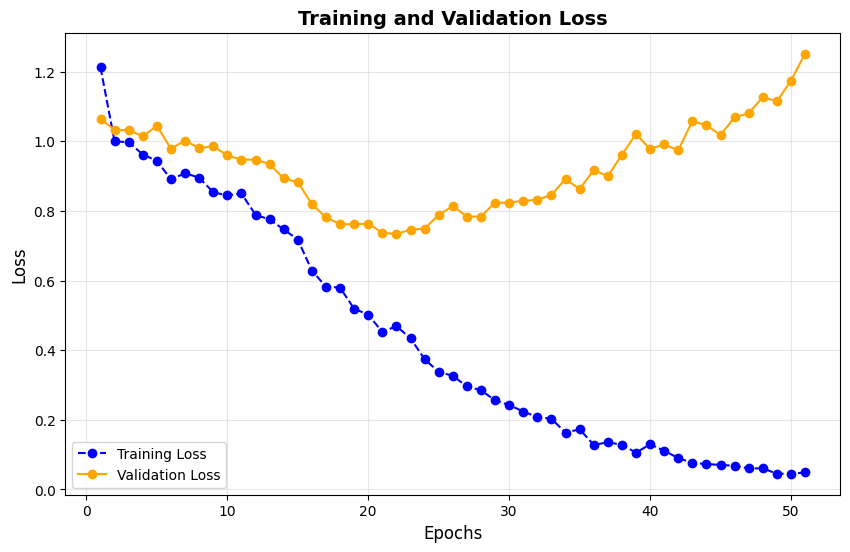

In [26]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="--", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o", linestyle="-", color="orange")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

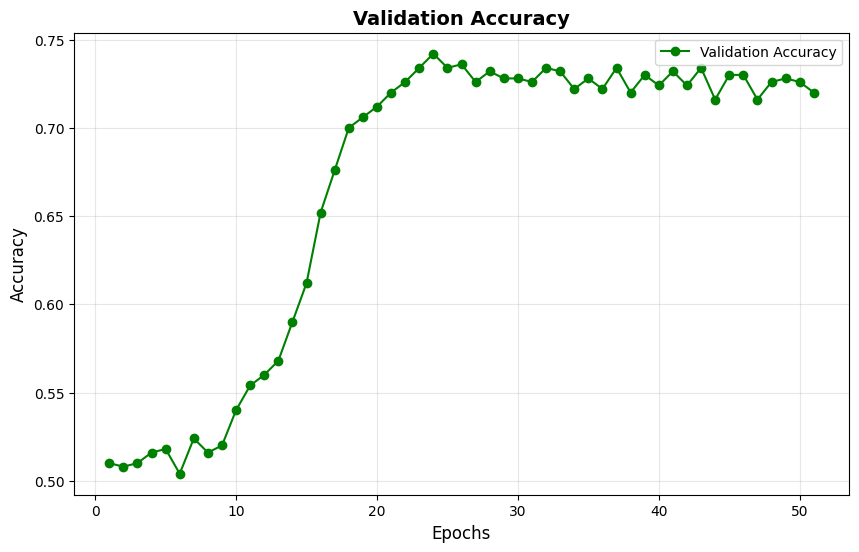

In [27]:
# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o", linestyle="-", color="green")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Validation Accuracy", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

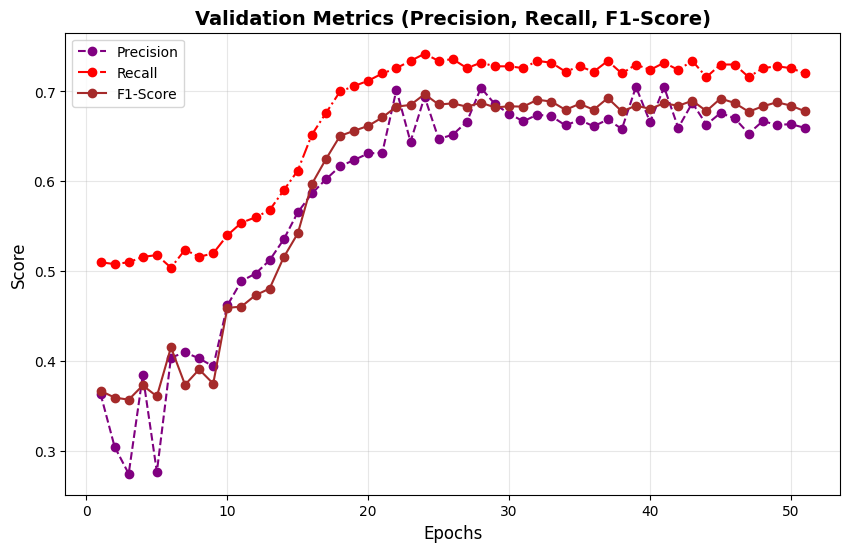

In [28]:
# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_precisions, label="Precision", marker="o", linestyle="--", color="purple")
plt.plot(epochs, val_recalls, label="Recall", marker="o", linestyle="-.", color="red")
plt.plot(epochs, val_f1_scores, label="F1-Score", marker="o", linestyle="-", color="brown")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Validation Metrics (Precision, Recall, F1-Score)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

### Generate soft label from teacher model

In [55]:
import torch.nn.functional as F
model.eval()

LoraClassificationModel(
  (lora_model): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): BioGptForCausalLM(
        (biogpt): BioGptModel(
          (embed_tokens): BioGptScaledWordEmbedding(57726, 1600, padding_idx=1)
          (embed_positions): BioGptLearnedPositionalEmbedding(2050, 1600)
          (layers): ModuleList(
            (0-47): 48 x BioGptDecoderLayer(
              (self_attn): BioGptSdpaAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1600, out_features=1600, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1600, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=1600, bias=False)
                  )
                  (lora

In [56]:
import json
with open("Data/PubMedQA_cleaned.json", "r") as f:
    raw_data = json.load(f)

In [ ]:
# OLD VERSION
# Function to build the prompt for the teacher model
def build_prompt(context, question):
    return f"""Read the article and answer the question with one of the following: No, Maybe, or Yes.

Article: {context}

Question: {question}

Answer:"""

# Define the options and their token IDs
option_words = ["no", "maybe", "yes"]
option_token_ids = [teacher_tokenizer.convert_tokens_to_ids(teacher_tokenizer.tokenize(w)[0]) for w in option_words]

# Generate soft labels from the teacher model
soft_dataset = []

for item in tqdm(raw_data[:1000], desc="Generating soft labels from teacher"):
    prompt = build_prompt(item["context"], item["question"])
    inputs = teacher_tokenizer(prompt, return_tensors="pt", truncation=True).to(device)

    with torch.no_grad():
        outputs = teacher_model(**inputs)
        logits = outputs.logits[0, -1]  # Get the logits for the last token

        probs = F.softmax(logits, dim=-1)

    option_probs = [probs[i].item() for i in option_token_ids]
    total = sum(option_probs)
    
    if total == 0:
        normalized_probs = [1.0 if i == item["gold_index"] else 0.0 for i in range(3)]
    else:
        normalized_probs = [p / total for p in option_probs]

    soft_dataset.append({
        "input_text": prompt,
        "soft_label": normalized_probs,
        "gold_index": item["gold_index"]
    })

print("Got soft labels:", len(soft_dataset))



Generating soft labels from teacher:  11%|█         | 106/1000 [00:10<01:27, 10.28it/s]


ZeroDivisionError: float division by zero

In [65]:
# NEW VERSION
T = 1.5

model.eval()

soft_dataset = []

for item in tqdm(raw_data[:1000], desc="Generating soft labels with classification head"):
    prompt = build_prompt(item["context"], item["question"])
    inputs = teacher_tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        with torch.amp.autocast(device_type=device):
            logits, _ = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
            logits = logits[0]  # shape: [3]

        # Apply temperature-scaled softmax
        log_probs = F.log_softmax(logits / T, dim=-1)
        probs = [float(torch.exp(lp)) for lp in log_probs]

        total = sum(probs)
        normalized_probs = [p / total for p in probs]

    soft_dataset.append({
        "input_text": prompt,
        "soft_label": normalized_probs,
        "gold_index": item["gold_index"]
    })

print("Got soft labels:", len(soft_dataset))


Generating soft labels with classification head: 100%|██████████| 1000/1000 [01:39<00:00, 10.10it/s]

Got soft labels: 1000


In [62]:
outputs.logits[0, -1].shape

torch.Size([57726])

In [69]:
# ✅ Save to JSON
output_path = f"soft_labels_T1.5.json"
with open(output_path, "w") as f:
    json.dump(soft_dataset, f, indent=2)
print(f"Saved soft labels with T={T} to {output_path}")

Saved soft labels with T=1.5 to soft_labels_T1.5.json


In [68]:
# teacher prediction: the index of max probability in soft_label
teacher_preds = [np.argmax(entry["soft_label"]) for entry in soft_dataset]

# ground truth: gold index from data
gold_labels = [entry["gold_index"] for entry in soft_dataset]

# compute accuracy
accuracy = np.mean(np.array(teacher_preds) == np.array(gold_labels))
print(f"Teacher soft label accuracy on current data: {accuracy:.4f}")

Teacher soft label accuracy on current data: 0.7330
